# Projet STA211 — Modélisation supervisée : Classification de publicités

Ce notebook fait suite à l’analyse exploratoire des données (01_EDA_Preprocessing), et se concentre sur la **modélisation supervisée** dans le cadre du projet STA211.

**Objectif** : prédire si une observation correspond à une publicité (`ad.`) ou non (`noad.`) à partir des données du jeu Internet Advertisements.

**Fichiers utilisés** :
- `data_train.csv` : données d’entraînement préalablement nettoyées et explorées
- `data_test.csv` : données de test à prédire

**Étapes couvertes ici** :
1. Préparation des données pour la modélisation (équilibration des données, standardisation…)
2. Implémentation de plusieurs modèles supervisés (logistique, arbres, forêts, etc.)
3. Évaluation comparative des performances (F1-score, AUC, matrice de confusion)
4. Gestion du déséquilibre des classes si nécessaire (SMOTE, pondération)
5. Génération d’un fichier `my_pred.csv` pour soumission

> Ce notebook suppose que le prétraitement initial (gestion des NA, exploration univariée et bivariée, transformations) a été réalisé dans le notebook EDA (`01_EDA_Preprocessing`).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os

def is_colab():
    """Détecte si le code s'exécute dans Google Colab."""
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

# === 1. Définir le chemin racine en fonction de l'environnement ===
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = "/content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025"
else:
    ROOT_DIR = r"C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025"

# === 2. Définir les dossiers du projet ===
MODULE_DIR      = os.path.join(ROOT_DIR, "modules")
RAW_DATA_DIR    = os.path.join(ROOT_DIR, "data", "raw")
DATA_PROCESSED  = os.path.join(ROOT_DIR, "data", "processed")
MODELS_DIR      = os.path.join(ROOT_DIR, "models")
FIGURES_DIR     = os.path.join(ROOT_DIR, "outputs", "figures")

# Créer les dossiers s’ils n’existent pas
for folder in [MODULE_DIR, RAW_DATA_DIR, DATA_PROCESSED, MODELS_DIR, FIGURES_DIR]:
    os.makedirs(folder, exist_ok=True)

# === 3. Ajouter MODULE_DIR au path pour l'import de modules maison ===
if MODULE_DIR not in sys.path:
    sys.path.insert(0, MODULE_DIR)

# === 4. Afficher les chemins pour vérification ===
print("Environnement : Colab" if is_colab() else "Environnement : local")
print("ROOT_DIR       =", ROOT_DIR)
print("MODULE_DIR     =", MODULE_DIR)
print("RAW_DATA_DIR   =", RAW_DATA_DIR)
print("DATA_PROCESSED =", DATA_PROCESSED)
print("FIGURES_DIR    =", FIGURES_DIR)
print("MODELS_DIR     =", MODELS_DIR)


Mounted at /content/drive
Environnement : Colab
ROOT_DIR       = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025
MODULE_DIR     = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/modules
RAW_DATA_DIR   = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/data/raw
DATA_PROCESSED = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/data/processed
FIGURES_DIR    = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/outputs/figures
MODELS_DIR     = /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/models


In [4]:
# === Importation des bibliothèques principales ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage plus lisible
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8')

# === Scikit-learn : preprocessing, modèles, évaluation ===
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    make_scorer
)

# === Modèles classiques ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# === Gestion du déséquilibre ===
from imblearn.over_sampling import SMOTE

# Supprimer les warnings inutiles
import warnings
warnings.filterwarnings('ignore')


# Chargement des données

In [5]:
from data_preprocessing import load_data

# Chemin complet vers le fichier CSV final
df_final_knn_path = os.path.join(DATA_PROCESSED, "df_final_knn.csv")

# Chargement des données
data = load_data(df_final_knn_path)


Dimensions du dataset: (2459, 180)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Columns: 180 entries, X4 to X3_boxcox
dtypes: float64(3), int64(176), object(1)
memory usage: 3.4+ MB

Aperçu des données :


,X4,outcome,X1244,X352,X1400,X969,X1345,X1436,X1230,X1119,...,X265,X963,X1133,X555,X1432,X1495,X870,X1_log,X2_boxcox,X3_boxcox
0,1,ad.,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,4.836282,9.870992,0.000000
1,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,3.526361,12.284012,2.056352
2,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.110874,15.640028,2.182903
3,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.110874,15.640028,2.182903
4,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.094345,15.550788,2.182411


# Préparation des données

In [6]:
pip install joblib

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import os

# === Séparation features / target ===
X = data.drop(columns=["outcome"])
y = (data["outcome"] == "ad.").astype(int)  # 1 si pub, 0 sinon

# === Split en train / test (80/20), avec stratification ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Sauvegarde des colonnes utilisées ===
columns_used = X_train.columns.tolist()
joblib.dump(columns_used, os.path.join(DATA_PROCESSED, "columns_used.pkl"))

# === Standardisation des données ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Rééquilibrage par SMOTE ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Vérification
print(f"Taille du train initial : {X_train.shape}")
print(f"Taille après SMOTE :     {X_train_res.shape}")
print("Distribution y (après SMOTE) :")
print(pd.Series(y_train_res).value_counts(normalize=True).round(3))


Taille du train initial : (1967, 179)
Taille après SMOTE :     (3384, 179)
Distribution y (après SMOTE) :
outcome
0    0.5
1    0.5
Name: proportion, dtype: float64


In [8]:
# Sauvegarde du scaler pour réutilisation sur d'autres jeux (ex: data_test.csv)
scaler_path = os.path.join(DATA_PROCESSED, "scaler_knn.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler sauvegardé à : {scaler_path}")

Scaler sauvegardé à : /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/data/processed/scaler_knn.pkl


# Définition des modèles

In [9]:
models = {
    "Logistic Regression": (
        LogisticRegression(solver='liblinear', max_iter=1000),
        {
            "C": [0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"]
        }
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {
            "max_depth": [5, 10, 20, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]  # p=1: Manhattan, p=2: Euclidean
        }
    ),
    "SVM": (
        SVC(probability=True),
        {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
    ),
    "Neural Net": (
        MLPClassifier(max_iter=1000, random_state=42),
        {
            "hidden_layer_sizes": [(100,), (50, 50), (100, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01]
        }
    )
}


# Entraînement avec optimisation F1

In [10]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import joblib

results = {}
best_overall_model = None
best_score = 0
best_model_name = ""

print("=== Entraînement et optimisation par validation croisée ===")

for name, (model, params) in models.items():
    print(f"\n🔍 Optimisation {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=make_scorer(f1_score),
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_res, y_train_res)
    best_model = grid.best_estimator_

    # Prédiction sur le test set d'origine (non resamplé)
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Affichage
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report :")
    print(classification_report(y_test, y_pred, digits=3))

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f"✅ F1-score : {f1:.4f}" + (f" | AUC : {auc:.4f}" if auc else ""))

    results[name] = (f1, auc)

    # Mise à jour si meilleur modèle
    if f1 > best_score:
        best_score = f1
        best_overall_model = best_model
        best_model_name = name

# Résumé final
print(f"\n🏆 Meilleur modèle : {best_model_name} (F1 = {best_score:.4f})")

# Sauvegarde du meilleur modèle sous un nom standard
best_model_path = os.path.join(MODELS_DIR, "best_model.joblib")
joblib.dump(best_overall_model, best_model_path)
print(f"📦 Meilleur modèle sauvegardé à : {best_model_path}")



=== Entraînement et optimisation par validation croisée ===

🔍 Optimisation Logistic Regression
Confusion Matrix :
[[405  18]
 [ 12  57]]
Classification Report :
              precision    recall  f1-score   support

           0      0.971     0.957     0.964       423
           1      0.760     0.826     0.792        69

    accuracy                          0.939       492
   macro avg      0.866     0.892     0.878       492
weighted avg      0.942     0.939     0.940       492

✅ F1-score : 0.7917 | AUC : 0.8827

🔍 Optimisation Decision Tree
Confusion Matrix :
[[407  16]
 [ 12  57]]
Classification Report :
              precision    recall  f1-score   support

           0      0.971     0.962     0.967       423
           1      0.781     0.826     0.803        69

    accuracy                          0.943       492
   macro avg      0.876     0.894     0.885       492
weighted avg      0.945     0.943     0.944       492

✅ F1-score : 0.8028 | AUC : 0.8857

🔍 Optimisation Ra

# Comparaison des scores

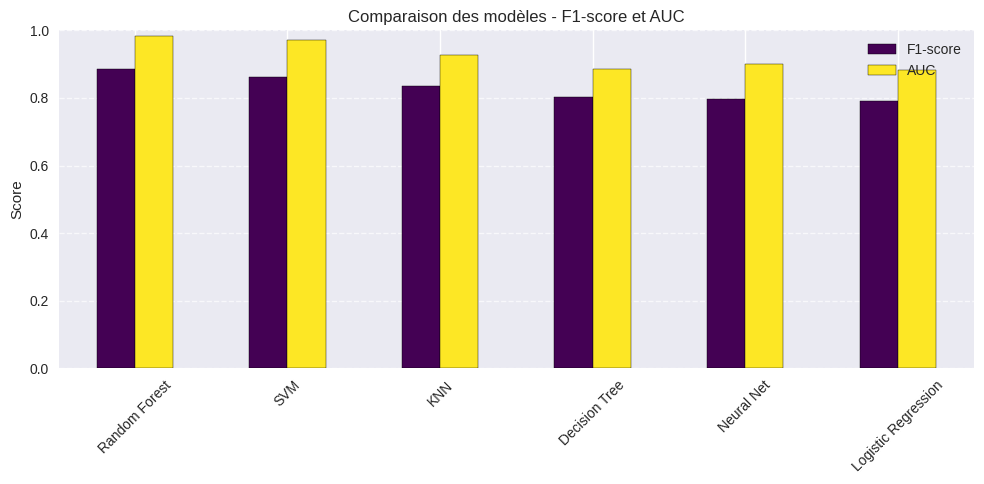

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Transformation des résultats en DataFrame
results_df = pd.DataFrame(results, index=["F1-score", "AUC"]).T.sort_values("F1-score", ascending=False)

# Tracé
fig, ax1 = plt.subplots(figsize=(10, 5))
results_df[["F1-score", "AUC"]].plot(kind="bar", ax=ax1, colormap="viridis", edgecolor="black")
plt.title("Comparaison des modèles - F1-score et AUC")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



## GridSearchCV sur StackingClassifier (RF final)

In [12]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score

# === Définition des modèles de base ===
base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
]

# === Stacking avec RandomForest final ===
stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    passthrough=False,
    cv=5,
    n_jobs=-1
)

# === Grille des hyperparamètres (base + final) ===
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'rf__n_estimators': [100, 200],
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__max_depth': [None, 10, 20]
}

# === Validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Grid Search
grid = GridSearchCV(stack_clf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# === Meilleur modèle
best_stacking_model = grid.best_estimator_
print(f"\n✅ Best F1-score: {grid.best_score_:.4f}")
print(f"📌 Best params: {grid.best_params_}")

# === Évaluation sur les prédictions
y_pred = best_stacking_model.predict(X_train)
y_prob = best_stacking_model.predict_proba(X_train)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

f1 = f1_score(y_train, y_pred)
auc = roc_auc_score(y_train, y_prob)
print(f"✅ Final F1-score : {f1:.4f} | AUC : {auc:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best F1-score: 0.9131
📌 Best params: {'final_estimator__max_depth': None, 'final_estimator__n_estimators': 200, 'rf__n_estimators': 100, 'svc__C': 1, 'svc__kernel': 'rbf'}

Confusion Matrix:
[[1689    3]
 [  17  258]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1692
           1       0.99      0.94      0.96       275

    accuracy                           0.99      1967
   macro avg       0.99      0.97      0.98      1967
weighted avg       0.99      0.99      0.99      1967

✅ Final F1-score : 0.9627 | AUC : 0.9917


In [13]:
joblib.dump(best_stacking_model, os.path.join(MODELS_DIR, "best_stacking_model.joblib"))

['/content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/models/best_stacking_model.joblib']

In [14]:
best_stacking_model = joblib.load(os.path.join(MODELS_DIR, "best_stacking_model.joblib"))

best_model = joblib.load(os.path.join(MODELS_DIR, "best_model.joblib"))
y_pred_rf = best_model.predict(X_train)
y_prob_rf = best_model.predict_proba(X_train)[:, 1]

f1_rf = f1_score(y_train, y_pred_rf)
auc_rf = roc_auc_score(y_train, y_prob_rf)
print(f"🎯 Random Forest (sauvegardé) — F1: {f1_rf:.4f} | AUC: {auc_rf:.4f}")


🎯 Random Forest (sauvegardé) — F1: 0.2453 | AUC: 0.7718


In [15]:
y_pred = best_stacking_model.predict(X_train)
y_prob = best_stacking_model.predict_proba(X_train)[:, 1]


f1 = f1_score(y_train, y_pred)
auc = roc_auc_score(y_train, y_prob)


results_df = pd.DataFrame({
    "Modèle": ["Random Forest (sauvé)", "Stacking Classifier"],
    "F1-score": [f1_rf, f1],
    "AUC": [auc_rf, auc]
})

display(results_df)



✅ F1-score stacking : 0.9627 | AUC : 0.9917


,Modèle,F1-score,AUC
0,Random Forest (sauvé),0.245317,0.771814
1,Stacking Classifier,0.962687,0.991675


## Importance des variables sur tout le stacking

🔍 Calcul de l'importance des variables par permutation...


,Feature,Importance,Std
177,X2_boxcox,0.032689,0.002840
2,X352,0.025826,0.003040
3,X1400,0.009964,0.001118
10,X399,0.006914,0.001459
178,X3_boxcox,0.005491,0.001416
7,X1230,0.004067,0.001326
176,X1_log,0.003660,0.001220
0,X4,0.002186,0.000684
153,X1381,0.001678,0.000233
144,X1263,0.001576,0.000153


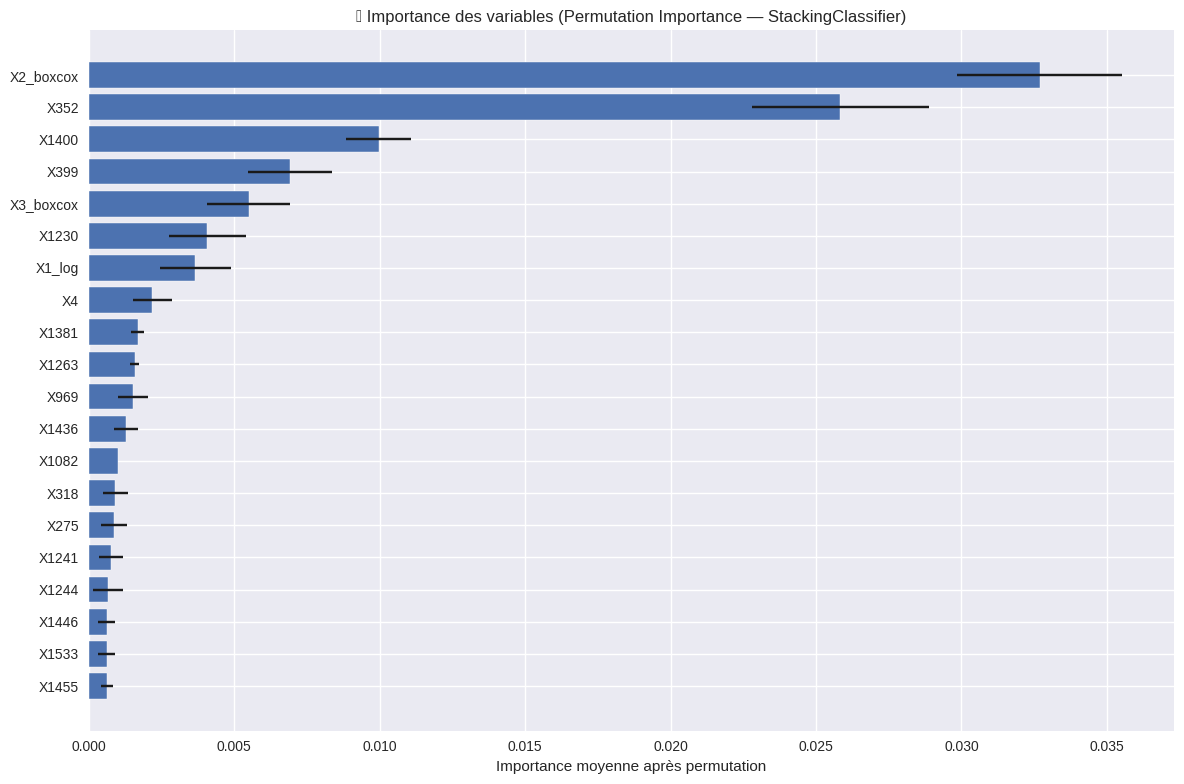

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Importance par permutation sur tout le pipeline (StackingClassifier)
print("🔍 Calcul de l'importance des variables par permutation...")

result = permutation_importance(
    best_stacking_model,  # Ton modèle complet
    X_train,               # Variables d'entraînement
    y_train,               # Cible
    n_repeats=10,          # Nombre de permutations (augmente pour plus de stabilité)
    random_state=42,
    n_jobs=-1
)

# === Mise en forme
perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# === Affichage du tableau trié
display(perm_importance_df.head(20))  # Top 20 pour lisibilité

# === Affichage graphique
plt.figure(figsize=(10, 7))
plt.barh(
    perm_importance_df['Feature'][:20][::-1],   # Top 20 inversé pour barre descendante
    perm_importance_df['Importance'][:20][::-1],
    xerr=perm_importance_df['Std'][:20][::-1],
    align='center'
)
plt.xlabel('Importance moyenne après permutation')
plt.title('🔍 Importance des variables (Permutation Importance — StackingClassifier)')
plt.grid(True)
plt.tight_layout()
plt.show()




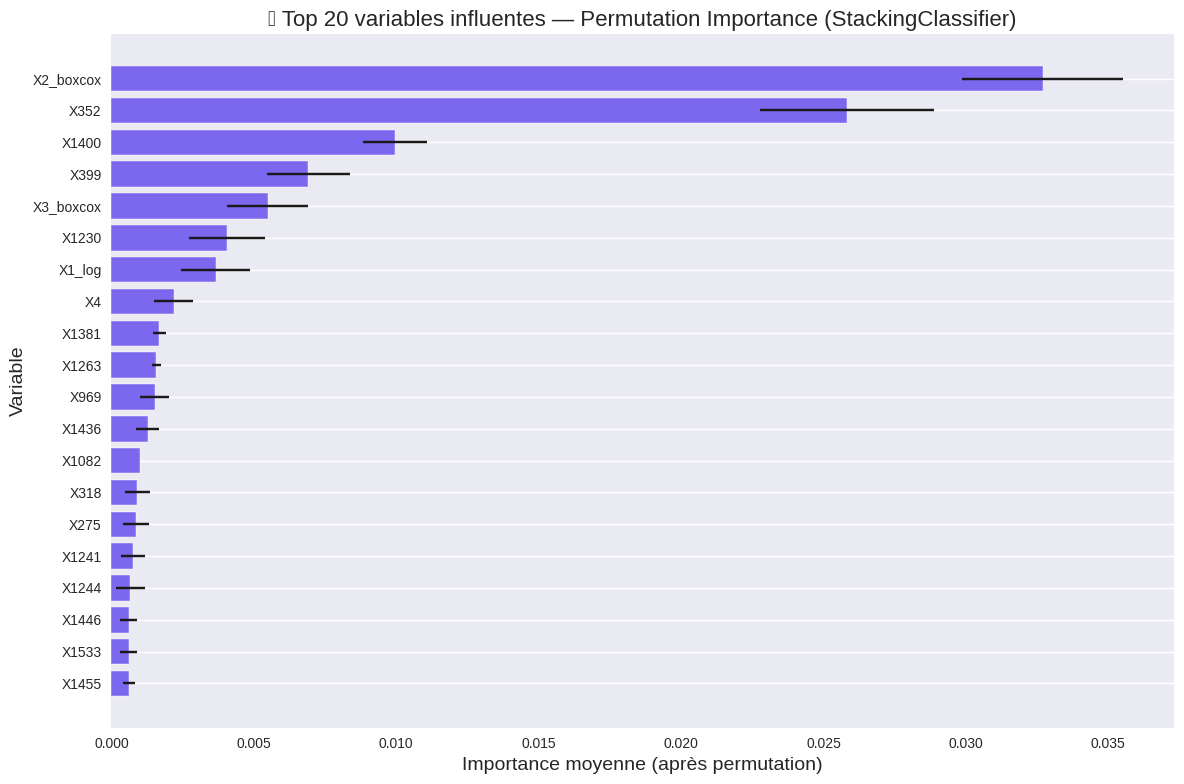

In [26]:

top_n = 20

# Extraire les données nécessaires
features = perm_importance_df.head(top_n)["Feature"]
importances = perm_importance_df.head(top_n)["Importance"]
std_errors = perm_importance_df.head(top_n)["Std"]

# Tracé
plt.figure(figsize=(12, 8))
plt.barh(
    features[::-1],        # Pour avoir le plus important en haut
    importances[::-1],
    xerr=std_errors[::-1],
    color="mediumslateblue",
    align="center"
)
plt.title(f"🎯 Top {top_n} variables influentes — Permutation Importance (StackingClassifier)", fontsize=16)
plt.xlabel("Importance moyenne (après permutation)", fontsize=14)
plt.ylabel("Variable", fontsize=14)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


## Sélection des Top 20 variables et reentrainement du modèle

In [27]:
# === Sélection des Top 20 variables
top_features = perm_importance_df.head(20)['Feature'].tolist()

X_train_top = X_train[top_features]

# === Définir un modèle simple sur les variables importantes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_top_features = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# === Validation croisée
scores = cross_val_score(
    rf_top_features,
    X_train_top,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"✅ F1-score moyen (5-fold CV) sur Top 20 variables : {np.mean(scores):.4f}")


✅ F1-score moyen (5-fold CV) sur Top 20 variables : 0.9181


## Sélection des Top 30 variables et reentrainement du modèle.

In [30]:
# === Sélection des Top 25 variables
top_25_features = perm_importance_df.head(25)['Feature'].tolist()

X_train_top25 = X_train[top_25_features]

# === Définir un modèle RandomForest sur Top 25
rf_top25 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# === Validation croisée
scores_top25 = cross_val_score(
    rf_top25,
    X_train_top25,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print(f"✅ F1-score moyen (5-fold CV) sur Top 25 variables : {np.mean(scores_top25):.4f}")


✅ F1-score moyen (5-fold CV) sur Top 25 variables : 0.9184


In [35]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Choix des tailles de Top variables à tester
top_n_list = [20, 25, 30, 40, 45, 50, 55, 60]

# === Stockage des résultats
f1_scores = []

# === Boucle sur chaque nombre de variables
for top_n in top_n_list:
    selected_features = perm_importance_df.head(top_n)['Feature'].tolist()
    X_selected = X_train[selected_features]

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(
        model,
        X_selected,
        y_train,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    f1_scores.append(np.mean(scores))

# === Résultats sous forme de DataFrame
ablation_results = pd.DataFrame({
    'Top_n_variables': top_n_list,
    'F1_score_5fold': f1_scores
})

display(ablation_results)



,Top_n_variables,F1_score_5fold
0,20,0.918067
1,25,0.918426
2,30,0.917571
3,40,0.921776
4,45,0.917372
5,50,0.914434
6,55,0.918135
7,60,0.918140


📊 Graphique ablation sauvegardé dans 'ablation_rf_plot.png'


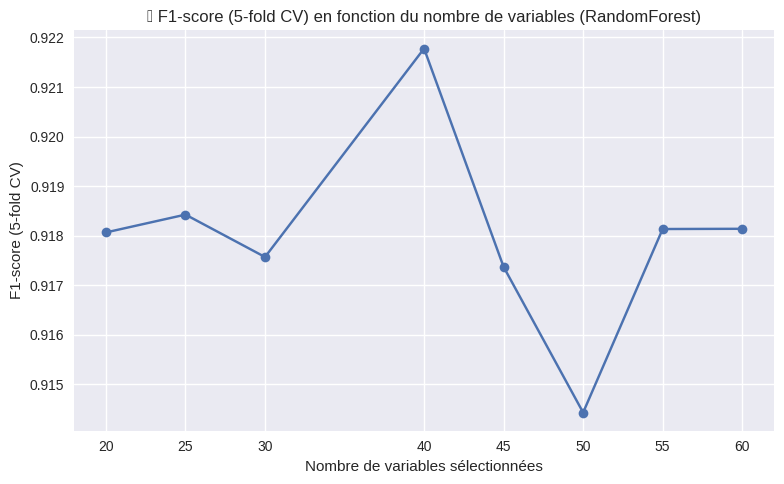

In [36]:
# === Regénérer et sauvegarder le graphique
plt.figure(figsize=(8, 5))
plt.plot(top_n_list, f1_scores, marker='o')
plt.title('🎯 F1-score (5-fold CV) en fonction du nombre de variables (RandomForest)')
plt.xlabel('Nombre de variables sélectionnées')
plt.ylabel('F1-score (5-fold CV)')
plt.grid(True)
plt.xticks(top_n_list)
plt.tight_layout()

# Sauvegarde
plt.savefig(os.path.join(FIGURES_DIR, "ablation_rf_plot.png"))
print("📊 Graphique ablation sauvegardé dans 'ablation_rf_plot.png'")

plt.show()


# Prédictions finales sur `data_test.csv`

In [38]:
from predict_preprocessing import generate_submission
import os

def choose_model_to_generate():
    """
    Permet de choisir interactifement quel modèle utiliser pour générer les prédictions sur data_test.csv.
    """
    print("Quel modèle veux-tu utiliser pour générer les prédictions ?")
    print("Options : 'stacking' (StackingClassifier complet) ou 'rf_top40' (RandomForest top 40 variables)")

    choice = input("Tape ton choix ici (stacking / rf_top40) : ").strip().lower()

    if choice == "stacking":
        model_file = "best_stacking_model.joblib"
    elif choice == "rf_top40":
        model_file = "best_rf_top40_model.joblib"
    else:
        print("❌ Choix invalide. Tape 'stacking' ou 'rf_top40'.")
        return

    print(f"\n✅ Génération des prédictions avec le modèle : {model_file} ...\n")

    generate_submission(
        test_file="data_test.csv",
        imputer_file="imputer_knn_k20.pkl",
        scaler_file="scaler_knn.pkl",
        model_file=model_file
    )

    print("\n🎯 Prédictions générées et enregistrées avec succès dans 'my_pred.csv'.")

# --- Utilisation : ---
choose_model_to_generate()


Quel modèle veux-tu utiliser pour générer les prédictions ?
Options : 'stacking' (StackingClassifier complet) ou 'rf_top40' (RandomForest top 40 variables)
Tape ton choix ici (stacking / rf_top40) : stacking

✅ Génération des prédictions avec le modèle : best_stacking_model.joblib ...

Dimensions du dataset: (820, 1558)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

Aperçu des données :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
2460,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2461,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2462,90.0,52.0,0.5777,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2463,60.0,468.0,7.8000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2464,90.0,60.0,0.6666,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


✅ Fichier de prédiction généré : /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/my_pred.csv

🎯 Prédictions générées et enregistrées avec succès dans 'my_pred.csv'.


In [ ]:
import joblib
best_model = joblib.load(os.path.join(MODELS_DIR, "best_model.joblib"))
best_stacking_model = joblib.load(os.path.join(MODELS_DIR, "best_stacking_model.joblib"))

In [23]:
from predict_preprocessing import generate_submission

generate_submission(
    test_file="data_test.csv",
    imputer_file="imputer_knn_k20.pkl",
    scaler_file="scaler_knn.pkl",
    model_file="best_stacking_model.joblib"
)


Dimensions du dataset: (820, 1558)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

Aperçu des données :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
2460,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2461,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2462,90.0,52.0,0.5777,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2463,60.0,468.0,7.8000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2464,90.0,60.0,0.6666,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


✅ Fichier de prédiction généré : /content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025/my_pred.csv


In [20]:
def read_pred(file, n=820):
    """Vérifie la conformité du fichier de prédiction au format attendu."""
    y_pred = pd.read_csv(file, header=None).squeeze()

    if len(y_pred) != n:
        raise ValueError(f"❌ Le fichier contient {len(y_pred)} lignes, attendu : {n}.")

    if y_pred.isnull().any():
        raise ValueError("❌ Le fichier contient des valeurs manquantes (NA).")

    unique_vals = set(y_pred.unique())
    if not unique_vals.issubset({"ad.", "noad."}):
        raise ValueError(f"❌ Valeurs invalides détectées : {unique_vals}")

    if len(unique_vals) == 1:
        print("⚠️ Avertissement : une seule classe prédite. Risque de sur-apprentissage.")

    print("✅ Fichier conforme. Prêt pour soumission.")
    return y_pred


# Validation locale du fichier

In [24]:
read_pred(os.path.join(ROOT_DIR, "my_pred.csv"))

✅ Fichier conforme. Prêt pour soumission.


,0
0,ad.
1,ad.
2,ad.
3,ad.
4,ad.
...,...
815,noad.
816,noad.
817,noad.
818,noad.
